# Imports

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Dense, Flatten, concatenate, Input, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load Tiny ImageNet Data

In [4]:
def load_dataset(dataset_dir, split='train', images_per_class=100, selected_classes=None):
    assert split in ['train', 'val'], "split must be 'train' or 'val'"
    split_dir = os.path.join(dataset_dir, split)

    images = []
    labels = []

    if split == 'train':
        for label_dir in os.listdir(split_dir):
            class_id = label_dir  # 'nXXXXXX'
            if selected_classes is not None and class_id not in selected_classes:
                continue  # Skip classes not in the selected subset
            class_dir = os.path.join(split_dir, label_dir, 'images')
            class_images = os.listdir(class_dir)[:images_per_class]  # Selecting only 100 images per class
            for image_file in class_images:
                image_path = os.path.join(class_dir, image_file)
                image = tf.keras.preprocessing.image.load_img(image_path, target_size=(64, 64))
                image = tf.keras.preprocessing.image.img_to_array(image)
                images.append(image)
                labels.append(class_id)
    elif split == 'val':
        val_annotations_path = os.path.join(split_dir, 'val_annotations.txt')
        with open(val_annotations_path, 'r') as f:
            val_annotations = f.readlines()
        
        class_counts = {}
        for line in val_annotations:
            items = line.strip().split('\t')
            image_file, class_id = items[0], items[1]
            if selected_classes is not None and class_id not in selected_classes:
                continue
            if class_id not in class_counts:
                class_counts[class_id] = 0
            if class_counts[class_id] < images_per_class:
                class_counts[class_id] += 1
                image_path = os.path.join(split_dir, 'images', image_file)
                image = tf.keras.preprocessing.image.load_img(image_path, target_size=(64, 64))
                image = tf.keras.preprocessing.image.img_to_array(image)
                images.append(image)
                labels.append(class_id)

    images = np.array(images)
    if labels:
        unique_labels = sorted(list(set(labels)))
        label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
        labels = np.array([label_to_id[label] for label in labels])
    else:
        labels = None

    return images, labels

dataset_dir = r'D:\Users\Nadeem\Desktop\BSDS\Semester 8\CV\AlexNet\tiny-imagenet-200'
selected_classes = ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 
                    'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750']

train_images, train_labels = load_dataset(dataset_dir, 'train', images_per_class=100, selected_classes=selected_classes)
val_images, val_labels = load_dataset(dataset_dir, 'val', images_per_class=100, selected_classes=selected_classes)

train_images, val_images = train_images / 255.0, val_images / 255.0

# Original GoogLeNet Architecture for a 224x224x3 input

In [3]:
def inception_module(x, filters):
    branch1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    branch3x3 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    branch3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(branch3x3)

    branch5x5 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    branch5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(branch5x5)

    branch_pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(branch_pool)

    output = concatenate([branch1x1, branch3x3, branch5x5, branch_pool], axis=3)
    return output

def GoogLeNet(input_shape, num_classes):
    input_layer = tf.keras.Input(shape=input_shape)

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [64, 96, 128, 16, 32, 32])
    x = inception_module(x, [128, 128, 192, 32, 96, 64])
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [192, 96, 208, 16, 48, 64])
    x = inception_module(x, [160, 112, 224, 24, 64, 64])
    x = inception_module(x, [128, 128, 256, 24, 64, 64])
    x = inception_module(x, [112, 144, 288, 32, 64, 64])
    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = inception_module(x, [384, 192, 384, 48, 128, 128])

    x = AveragePooling2D((7, 7), strides=(1, 1))(x)
    x = Dropout(0.4)(x)

    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=x)
    return model

input_shape = (224, 224, 3)
num_classes = 1000

model = GoogLeNet(input_shape, num_classes)
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 56, 56, 64)           4160      ['max_pooling2d[0][0]'] 

# Modified Architecture for a 64x64x3 input

In [5]:
def inception_module(x, filters):
    # 1x1
    branch1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    # 3x3
    branch3x3 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    branch3x3 = Conv2D(filters[1], (3, 3), padding='same', activation='relu')(branch3x3)

    # 5x5 replaced with 3x3 to reduce complexity
    branch5x5 = Conv2D(filters[2], (1, 1), padding='same', activation='relu')(x)
    branch5x5 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(branch5x5)

    # 3x3 max pool
    branch_pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = Conv2D(filters[2], (1, 1), padding='same', activation='relu')(branch_pool)

    # Concatenate filters, assumes filters are concatenated along the last dimension
    output = concatenate([branch1x1, branch3x3, branch5x5, branch_pool], axis=-1)
    return output

def GoogLeNet(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # Starting with fewer filters to reduce complexity
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)

    x = Conv2D(32, (1, 1), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)

    # Reduce the number of filters in the inception modules
    x = inception_module(x, [32, 32, 32])
    x = inception_module(x, [64, 64, 64])
    x = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)

    # Further reduced complexity in inception modules
    x = inception_module(x, [64, 64, 64])
    x = inception_module(x, [64, 64, 64])

    # Adjusting the size of the average pooling layer to match the new spatial dimensions
    x = AveragePooling2D((2, 2), strides=(1, 1))(x)
    x = Dropout(0.4)(x)

    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=x)
    return model

input_shape = (64, 64, 3)
num_classes = 10

model = GoogLeNet(input_shape, num_classes)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_27 (Conv2D)          (None, 64, 64, 32)           896       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_7 (MaxPoolin  (None, 64, 64, 32)           0         ['conv2d_27[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_28 (Conv2D)          (None, 64, 64, 32)           1056      ['max_pooling2d_7[0][0]'

# Training

In [6]:
optimizer = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning Rate Scheduler
def lr_schedule(epoch, lr):
    # Decrease the learning rate by 4% every 8 epochs
    if epoch > 0 and epoch % 8 == 0:
        return lr * 0.96
    else:
        return lr

class PolyakAveraging(tf.keras.callbacks.Callback):
    def __init__(self, model, beta=0.998):
        super(PolyakAveraging, self).__init__()
        self.model = model
        self.beta = beta
        self.shadow_weights = [tf.identity(w) for w in model.weights]
        
    def on_batch_end(self, batch, logs=None):
        new_shadow_weights = []
        for shadow_weight, model_weight in zip(self.shadow_weights, self.model.weights):
            new_shadow_weight = self.beta * shadow_weight + (1 - self.beta) * model_weight
            new_shadow_weights.append(new_shadow_weight)
        self.shadow_weights = new_shadow_weights
        
    def on_epoch_end(self, epoch, logs=None):
        # Assign the Polyak averaged weights to the model
        for model_weight, shadow_weight in zip(self.model.weights, self.shadow_weights):
            model_weight.assign(shadow_weight)

# Preprocess and augment data.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# One-hot encode the labels
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes)

# Prepare data generators.
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
val_generator = val_datagen.flow(val_images, val_labels, batch_size=32)

# Instantiate the PolyakAveraging callback
polyak_cb = PolyakAveraging(model)

# Training the model with callbacks
history = model.fit(train_generator, 
                    epochs=100, 
                    validation_data=val_generator,
                    callbacks=[
                        ModelCheckpoint('googlenet_best.h5', save_best_only=True), 
                        LearningRateScheduler(lr_schedule),
                        polyak_cb
                    ])

# Evaluate the model.
evaluation = model.evaluate(val_generator)
print(f'Validation Accuracy: {evaluation[1] * 100:.2f}%')

Epoch 1/100



32/32 [==============================] - ETA: 0s - loss: 2.3042 - accuracy: 0.0830

c:\Users\Fatima Azfar\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 156s 4s/step - loss: 2.3042 - accuracy: 0.0830 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0100
Epoch 2/100
32/32 [==============================] - 129s 4s/step - loss: 2.3046 - accuracy: 0.0850 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0100
Epoch 3/100
32/32 [==============================] - 124s 4s/step - loss: 2.3036 - accuracy: 0.0910 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0100
Epoch 4/100
32/32 [==============================] - 119s 4s/step - loss: 2.3046 - accuracy: 0.0780 - val_loss: 2.3026 - val_accuracy: 0.1000 - lr: 0.0100
Epoch 5/100
32/32 [==============================] - 123s 4s/step - loss: 2.3040 - accuracy: 0.0940 - val_loss: 2.3027 - val_accuracy: 0.1000 - lr: 0.0100
Epoch 6/100
32/32 [==============================] - 128s 4s/step - loss: 2.3039 - accuracy: 0.0890 - val_loss: 2.3026 - val_accuracy: 0.1000 - lr: 0.0100
Epoch 7/100
32/32 [==============================] - 163s 5s/step - loss: 2.3046 -

# Model Training Visualizations

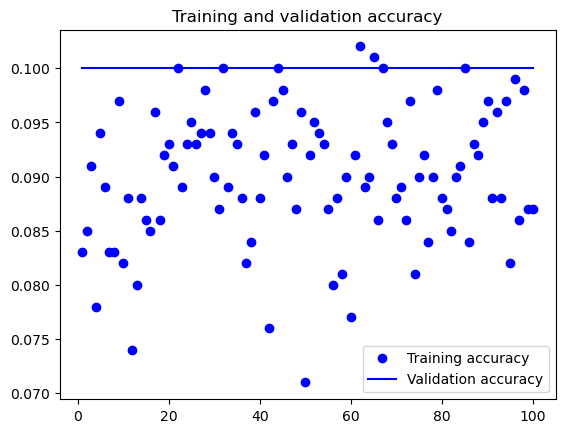

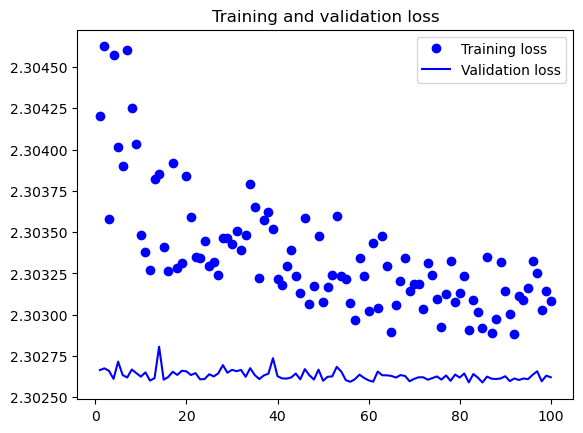

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Top k val error & accuracy

In [8]:
# predictions on the validation set
val_predictions = model.predict(val_images)

# top-1 error rate
val_top1_errors = np.argmax(val_predictions, axis=1) != val_labels
val_top1_error_rate = np.mean(val_top1_errors)
val_top1_accuracy = 1 - val_top1_error_rate
print("Validation Top-1 Error Rate:", val_top1_error_rate)
print("Validation Top-1 Accuracy:", val_top1_accuracy)

# top-5 error rate
val_top5_errors = np.ones_like(val_top1_errors)
for i in range(len(val_predictions)):
    val_top5_indices = np.argsort(val_predictions[i])[-5:]
    if val_labels[i] in val_top5_indices:
        val_top5_errors[i] = 0
val_top5_error_rate = np.mean(val_top5_errors)
val_top5_accuracy = 1 - val_top5_error_rate
print("Validation Top-5 Error Rate:", val_top5_error_rate)
print("Validation Top-5 Accuracy:", val_top5_accuracy)

16/16 [==============================] - 13s 757ms/step
Validation Top-1 Error Rate: 1.0
Validation Top-1 Accuracy: 0.0
Validation Top-5 Error Rate: 1.0
Validation Top-5 Accuracy: 0.0


C:\Users\Fatima Azfar\AppData\Local\Temp\ipykernel_16532\1141859120.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  val_top1_errors = np.argmax(val_predictions, axis=1) != val_labels
C:\Users\Fatima Azfar\AppData\Local\Temp\ipykernel_16532\1141859120.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if val_labels[i] in val_top5_indices:


**Note:** The accuracy and learning is awful as I could not train it on the actual architecture because of the limitations of my system, and because the data was too large to be uploaded anywhere, I could not train it on Kaggle or Colab, I will try to load only the 10 classes that I am using to Colab but because this took 3+ hours to run I could not do that.